In [1]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

import scipy.stats

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov3_allmodels.csv")
kiran_data = utils.prep_nlst_preds(kiran_nodule, scanlevel=True, sybil=False, tijmen=False)
print(len(kiran_data), "Scans")

10183 Scans


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v3_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
nlst_democols['cat'].pop('nodule')
nlst_democols['num'].pop('nodule')
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'c

In [5]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_list = cols_num + cols_cat

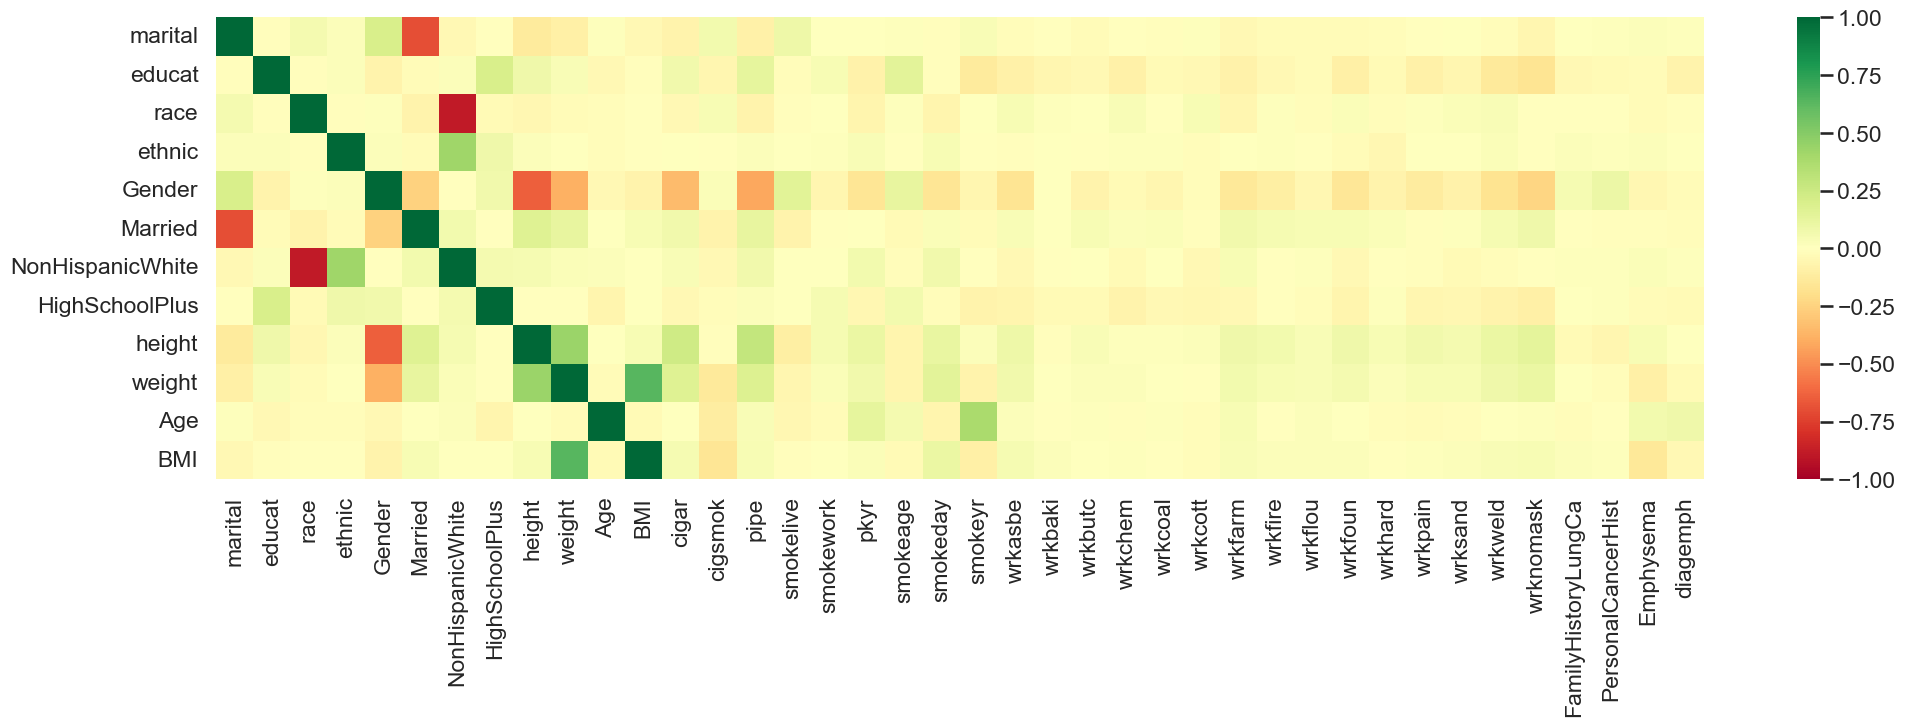

In [6]:
# corrmat = kiran_data[cols_list].corr(method='kendall').round(2)
corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['work'] + nlst_democols['cat']['other'] + ['diagemph']

corrmat = utils.corrmat(kiran_data, corr_rows, corr_cols)

In [7]:
def testlink_cat_cat(df0, col1, col2, debug=False):
    df = df0.dropna(subset=[col1, col2], axis=0)
    if debug: display(Markdown(f"### {col1} and {col2}"))
    contingency_table = pd.crosstab(df[col1], df[col2])
    if debug: display(contingency_table)

    chi2_result = scipy.stats.chi2_contingency(contingency_table)
    if debug: 
        print("stat:\t", chi2_result.statistic)
        print("pval:\t", chi2_result.pvalue)
        print("dof:\t", chi2_result.dof)

    cramer_v = scipy.stats.contingency.association(contingency_table, method='cramer')
    if debug: print("Cramer:\t", cramer_v)
    return cramer_v, chi2_result.pvalue

testlink_cat_cat(kiran_data, 'Married', 'Gender', debug=True)

### Married and Gender

Gender,1,2
Married,,
False,1303,2025
True,4531,2324


stat:	 663.6672470325547
pval:	 2.3812298985172768e-146
dof:	 1
Cramer:	 0.25550369525856476


(0.25550369525856476, np.float64(2.3812298985172768e-146))

In [8]:
### Pearson correlation
def testlink_num_num(df0, col1, col2, debug=False, r_func=scipy.stats.kendalltau):
    if debug: display(Markdown(f"### {col1} and {col2}"))
    df = df0.dropna(subset=[col1, col2], axis=0)
    stat, pval = r_func(df[col1], df[col2], alternative='two-sided')
    if debug: 
        print("stat:\t", stat)
        print("pval:\t", pval)
    return stat, pval

testlink_num_num(kiran_data, 'Age', 'weight', debug=True)

### Age and weight

stat:	 -0.024219494908991723
pval:	 0.0004071353068128385


(np.float64(-0.024219494908991723), np.float64(0.0004071353068128385))

In [9]:
def testlink_cat_num(df0, col_cat, col_num, debug=False):
    if debug: display(Markdown(f"### {col_cat} and {col_num}"))
    df = df0.dropna(subset=[col_cat, col_num], axis=0)
    dfbycat = df.groupby(col_cat)
    samples = {val: dfg[col_num] for val, dfg in dfbycat}

    if debug:
        for val in samples:
            display(Markdown(f"#### {val}"))
            print("mean:", samples[val].mean())
            print("std:", samples[val].std())
            print("median:", samples[val].median())
    
    stat, pval = scipy.stats.kruskal(*list(samples.values()), axis=0)
    display(Markdown(f"#### Kruskal-Wallis H-test results"))
    if debug: 
        print("stat:\t", stat)
        print("pval:\t", pval)
    
    return stat, pval

testlink_cat_num(kiran_data, 'Married', 'Age', debug=True)

### Married and Age

#### False

mean: 63.18088942307692
std: 5.236892107365422
median: 63.0


#### True

mean: 63.21663019693654
std: 5.242044901299023
median: 62.0


#### Kruskal-Wallis H-test results

stat:	 0.07758086433532128
pval:	 0.7806029165434643


(np.float64(0.07758086433532128), np.float64(0.7806029165434643))

In [10]:
MODEL_TO_COL = {
    "Venkadesh": "DL",
    "de Haas Combined": "Thijmen_mean",
    "de Haas Local": "Thijmen_local",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "Sybil year 1": "sybil_year1",
    "Sybil year 2": "sybil_year2",
    "Sybil year 3": "sybil_year3",
    "Sybil year 4": "sybil_year4",
    "Sybil year 5": "sybil_year5",
    "Sybil year 6": "sybil_year6",
    "PanCan2b": "PanCan2b",
}

In [11]:
set_cat = set(cols_cat + ['label'])
set_num = set(cols_num + list(MODEL_TO_COL.values()))
len(set_num), len(set_cat), len(set_cat.intersection(set_num))

(22, 63, 0)

In [12]:
def pval_corr_value(df, col1, col2, debug=False):
    col1type = "cat" if (col1 in set_cat) else "num"
    col2type = "cat" if (col2 in set_cat) else "num"
    types = sorted([col1type, col2type])

    if debug:
        print(f"{col1} is {col1type}")
        print(f"{col2} is {col2type}")
    
    if types == ['cat', 'cat']: stat, pval = testlink_cat_cat(df, col1, col2, debug)
    if types == ['num', 'num']: stat, pval = testlink_num_num(df, col1, col2, debug)
    if col1type == 'cat' and col2type == 'num':
        stat, pval = testlink_cat_num(df, col1, col2, debug)
    if col2type == 'cat' and col1type == 'cat':
        stat, pval = testlink_cat_num(df, col2, col1, debug)
    
    return 1 - abs(pval)

In [13]:
def pval_corr_callable(arr1, arr2):
    if pd.Series(arr1).equals(pd.Series(arr2)): return 1
    df = pd.DataFrame({"var1": arr1, 'var2': arr2})
    return pval_corr_value(df, "var1", "var2", debug=False)

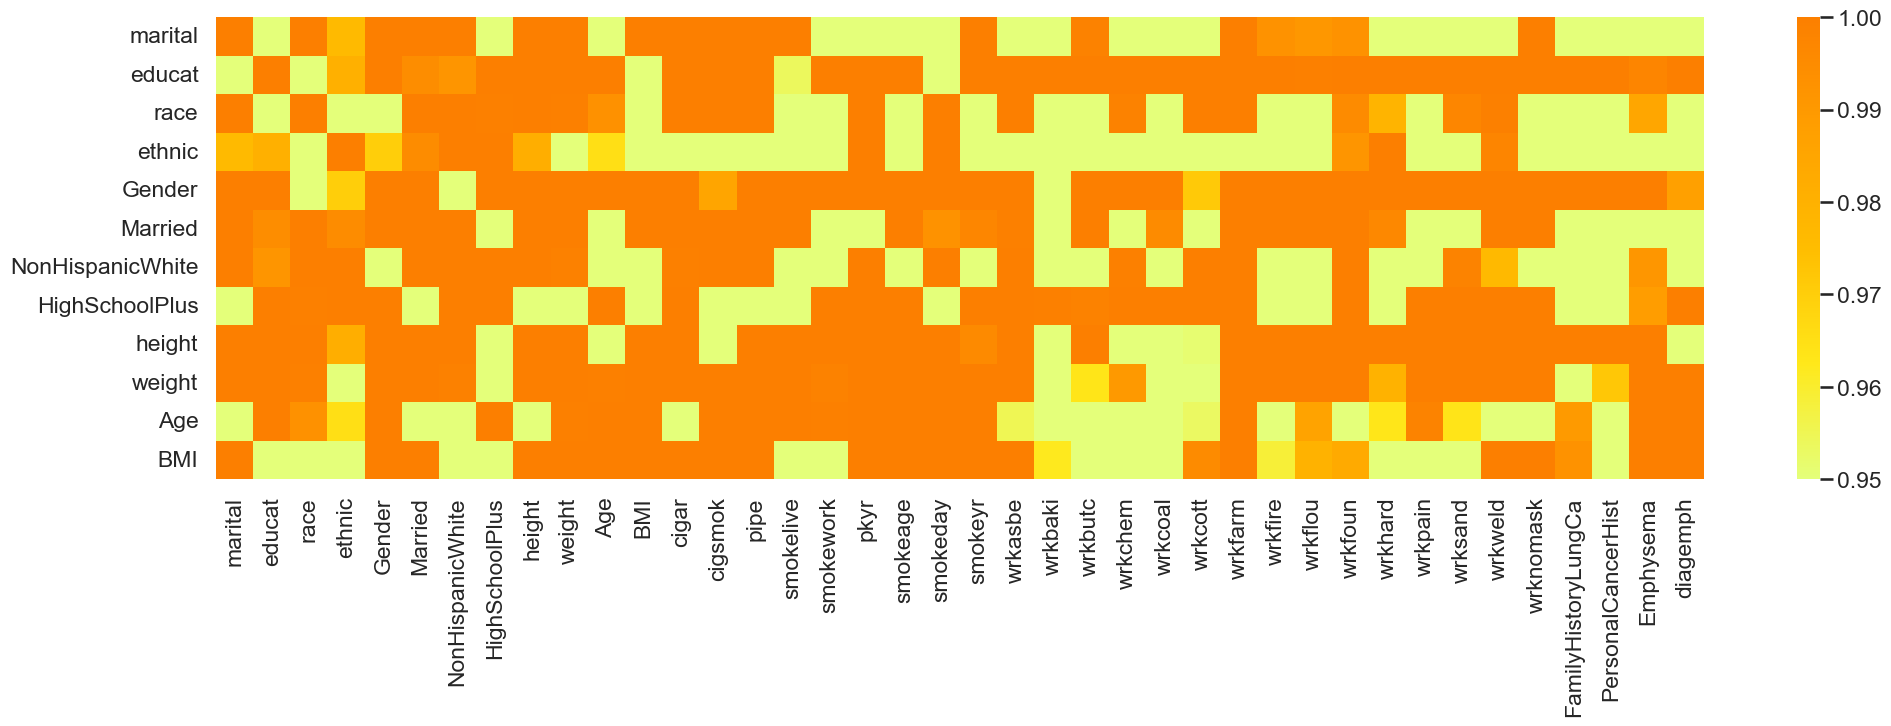

In [14]:
_ = utils.corrmat(kiran_data, corr_rows, corr_cols, method=pval_corr_callable, vmin=0.95, vmax=1, cmap='Wistia')

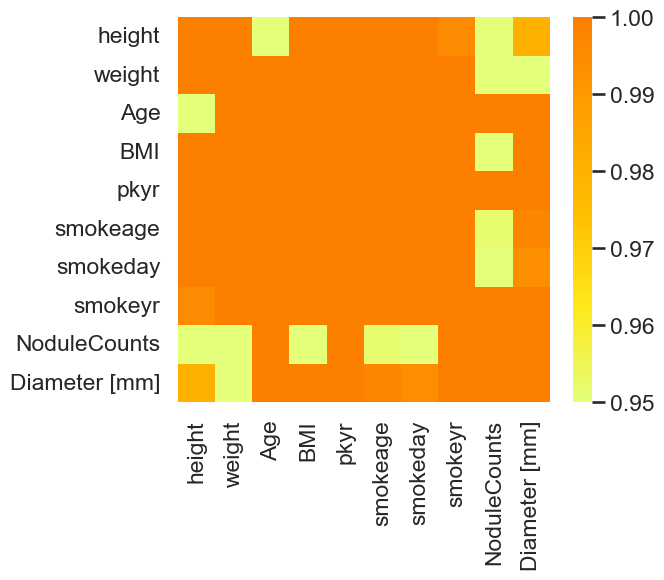

In [15]:
_ = utils.corrmat(kiran_data, cols_num, cols_num, method=pval_corr_callable, vmin=0.95, vmax=1, cmap='Wistia')

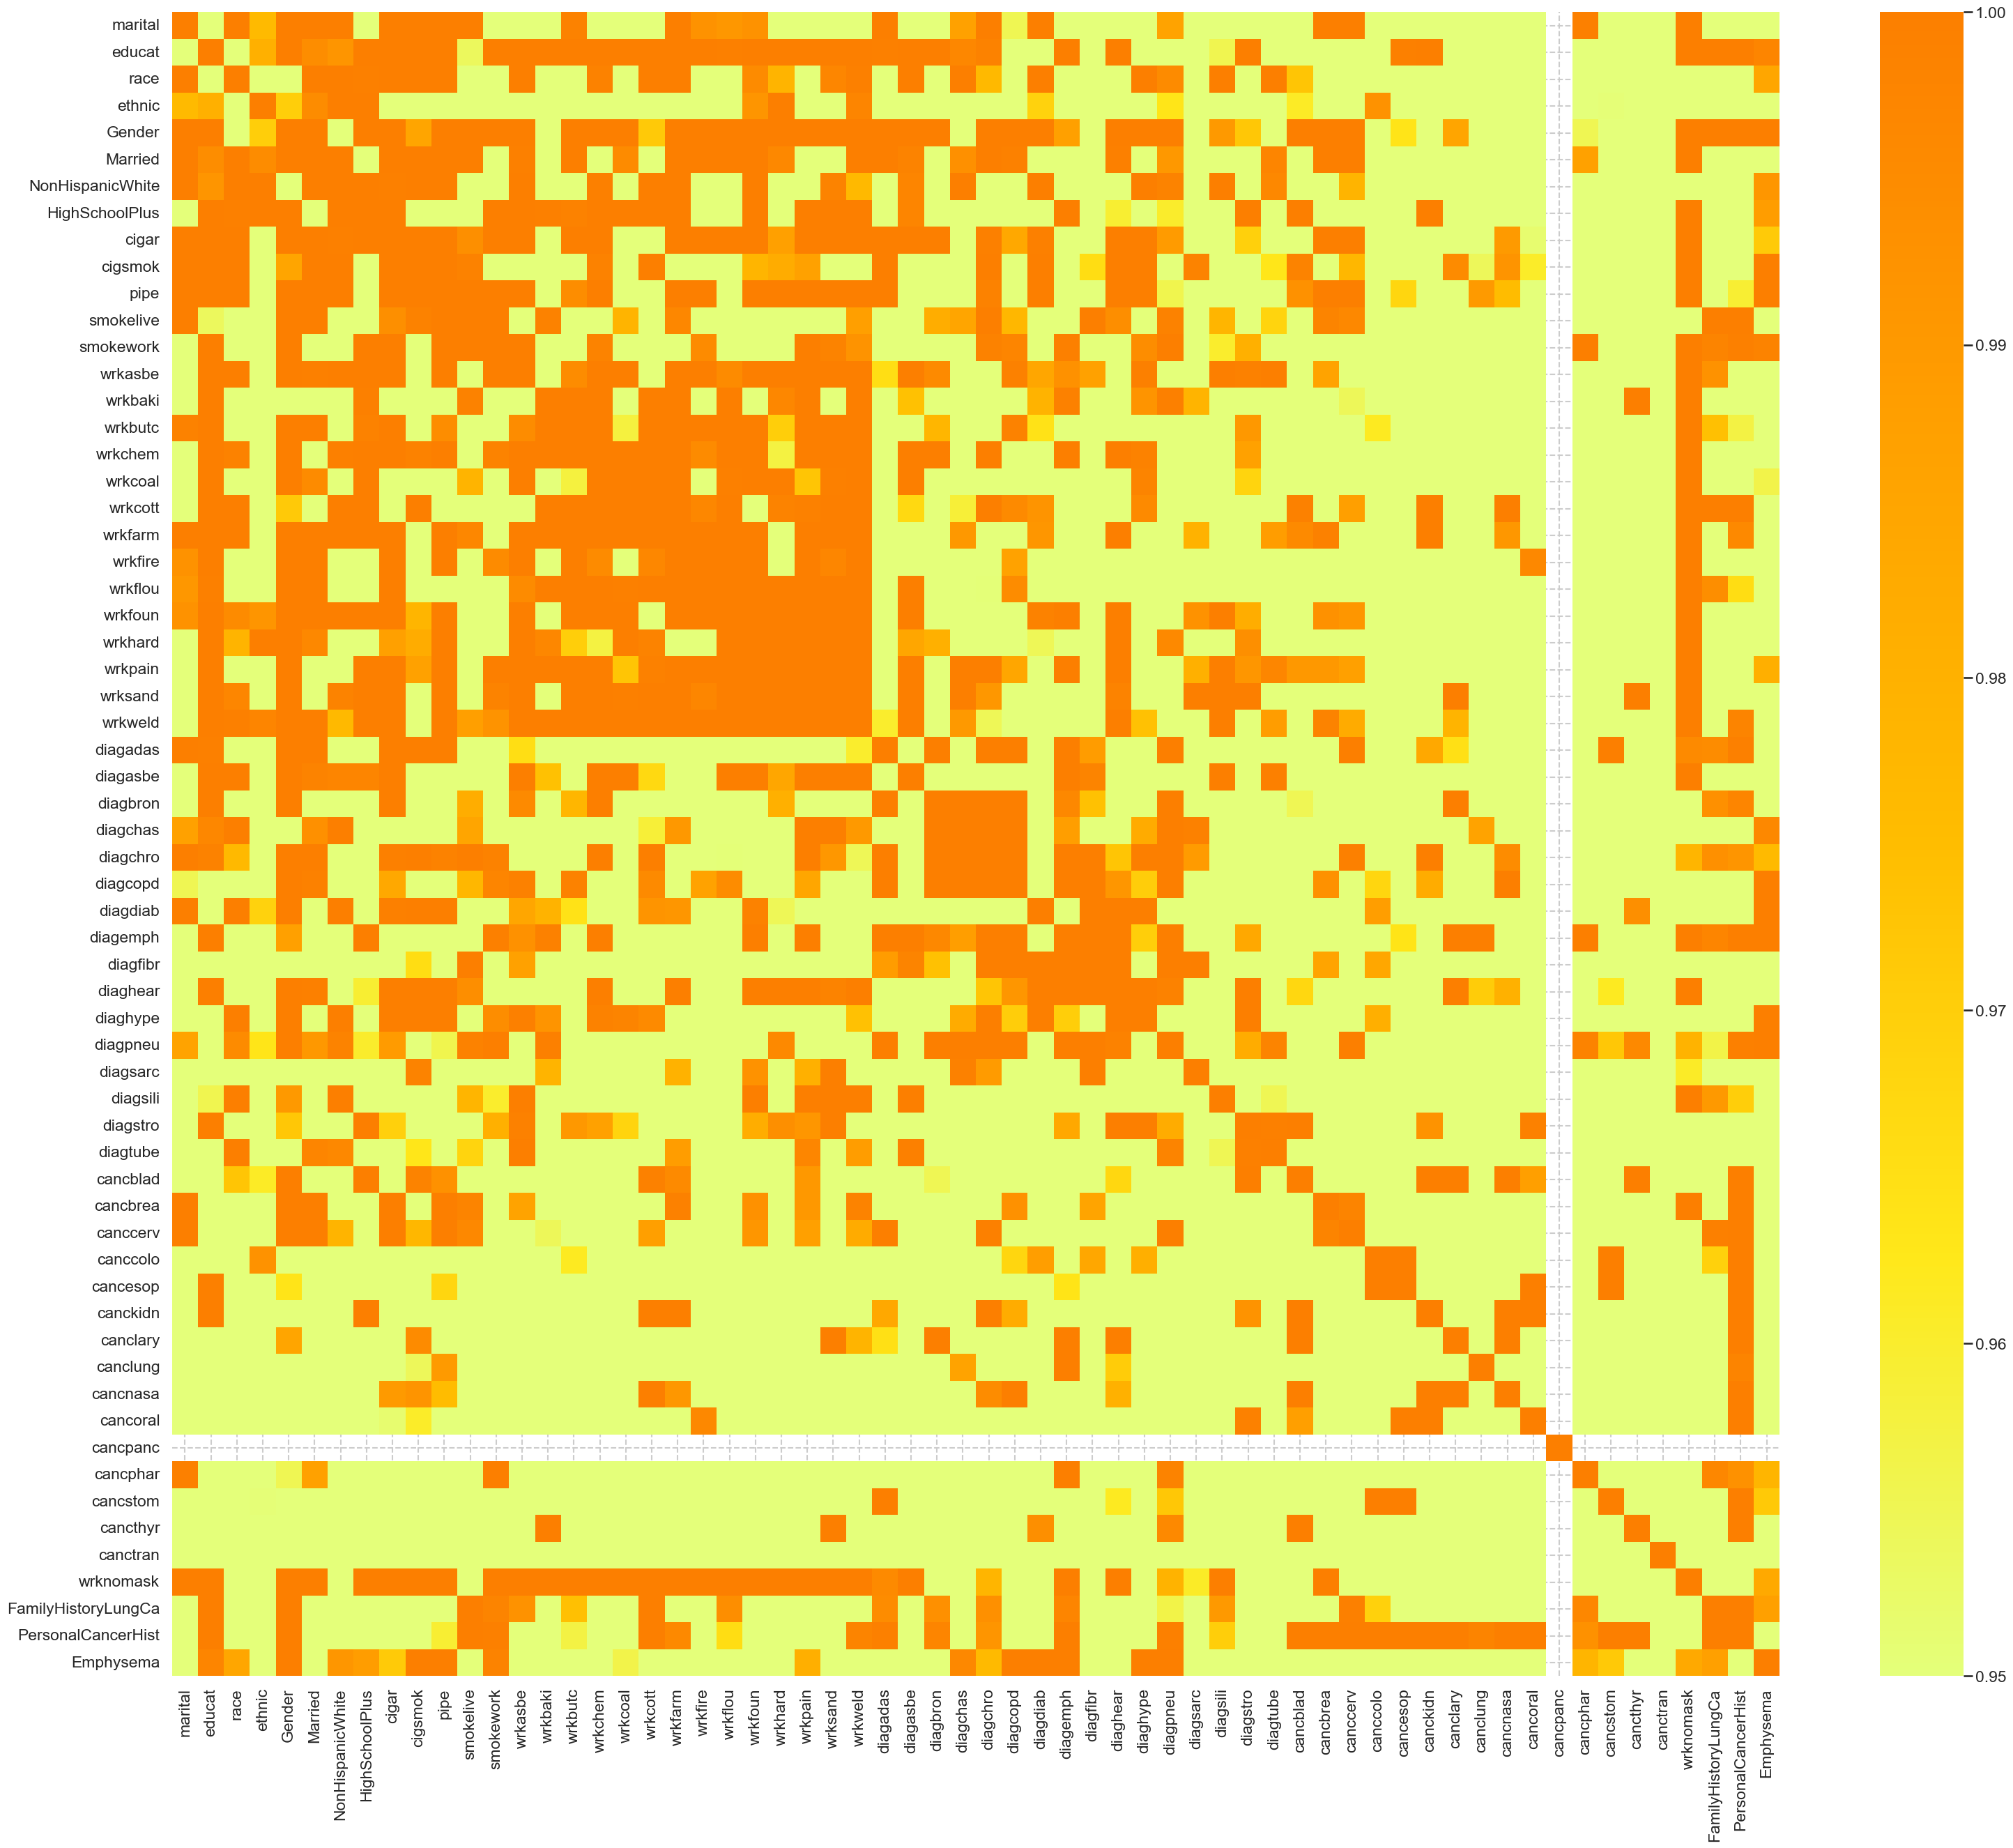

In [16]:
_ = utils.corrmat(kiran_data, cols_cat, cols_cat, method=pval_corr_callable, vmin=0.95, vmax=1, cmap='Wistia')

In [17]:
sybil_worse_df = pd.read_csv(f"{NLST_PREDS}/sybil_worse.csv")
sybil_worse_df

,col,sym,val
0,wrknomask,=,True
1,FamilyHistoryLungCa,=,True
2,Emphysema,=,True
3,Gender,=,1
4,Married,=,True
5,wrkasbe,=,1
6,wrkfoun,=,1
7,diagadas,=,1
8,diagcopd,=,1
9,diagpneu,=,1


In [24]:
cols = list(set(list(sybil_worse_df['col']) + nlst_democols['cat']['demo'] + nlst_democols['num']['demo'])) + list(MODEL_TO_COL.values()) + ['label']
cols

['BMI',
 'Diameter [mm]',
 'FamilyHistoryLungCa',
 'wrkasbe',
 'diagpneu',
 'Married',
 'HighSchoolPlus',
 'diagadas',
 'race',
 'weight',
 'NonHispanicWhite',
 'ethnic',
 'diagcopd',
 'wrknomask',
 'Age',
 'marital',
 'height',
 'NoduleCounts',
 'Gender',
 'wrkfoun',
 'Emphysema',
 'educat',
 'DL',
 'Thijmen_mean',
 'Thijmen_local',
 'Thijmen_global_hidden',
 'Thijmen_global_show',
 'sybil_year1',
 'sybil_year2',
 'sybil_year3',
 'sybil_year4',
 'sybil_year5',
 'sybil_year6',
 'PanCan2b',
 'label']

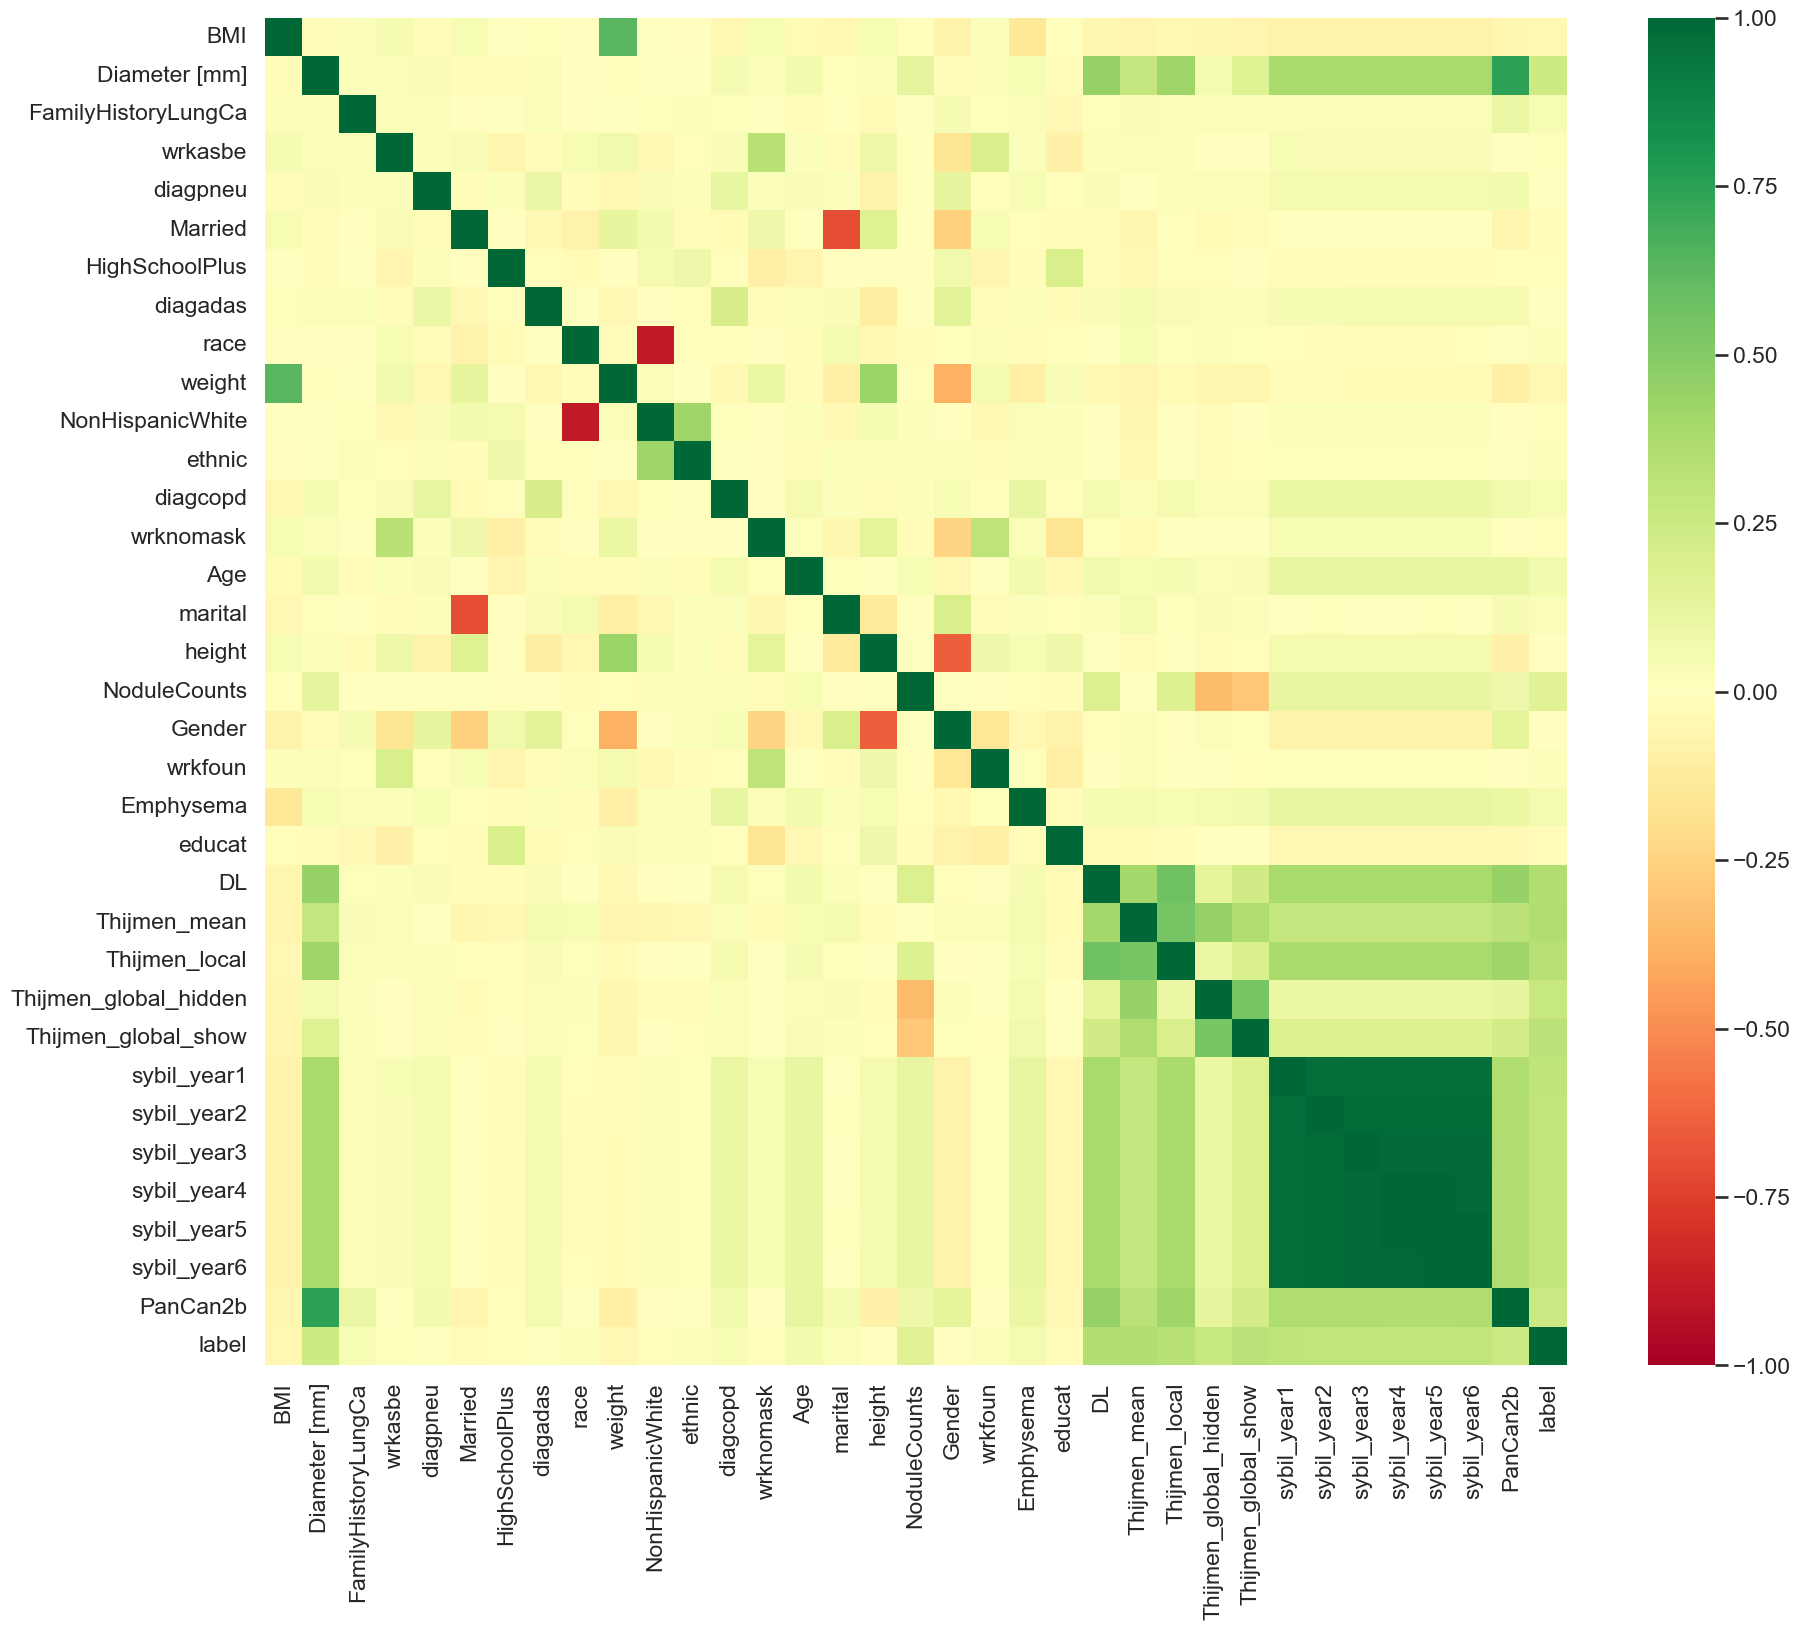

,sybil_year2,BMI,PanCan2b,Diameter [mm],Thijmen_global_show,FamilyHistoryLungCa,wrkasbe,diagpneu,Married,HighSchoolPlus,...,sybil_year5,marital,label,height,NoduleCounts,Gender,wrkfoun,Emphysema,educat,sybil_year1
sybil_year2,1.000000,-0.075153,0.361384,0.386006,0.179943,0.025103,0.038895,0.056813,0.004219,-0.027395,...,0.979903,0.007816,0.296114,0.058048,0.115678,-0.074364,0.011317,0.112668,-0.049345,0.976550
BMI,-0.075153,1.000000,-0.059436,-0.023683,-0.065903,0.021772,0.047141,-0.023653,0.044668,0.002275,...,-0.077404,-0.041656,-0.049724,0.044715,-0.009655,-0.072715,0.019382,-0.144736,-0.009784,-0.073029
PanCan2b,0.361384,-0.059436,1.000000,0.748835,0.219006,0.093864,0.004103,0.064506,-0.069126,-0.015517,...,0.359264,0.047162,0.257757,-0.089275,0.083831,0.134585,-0.007191,0.107731,-0.039148,0.363512
Diameter [mm],0.386006,-0.023683,0.748835,1.000000,0.170147,0.021471,0.031026,0.038798,-0.026860,-0.019901,...,0.382995,0.013989,0.245995,0.016099,0.127035,-0.023208,0.023812,0.041791,-0.020805,0.388196
Thijmen_global_show,0.179943,-0.065903,0.219006,0.170147,1.000000,0.029617,-0.000686,0.023945,-0.017104,-0.006230,...,0.179114,0.020043,0.313729,-0.010576,-0.293790,0.008895,-0.009318,0.074887,0.006661,0.180849
FamilyHistoryLungCa,0.025103,0.021772,0.093864,0.021471,0.029617,1.000000,0.026579,0.020029,-0.000038,0.007544,...,0.024650,0.004976,0.042696,-0.035270,0.004275,0.053660,0.009358,0.024785,-0.040637,0.024336
wrkasbe,0.038895,0.047141,0.004103,0.031026,-0.000686,0.026579,1.000000,0.015942,0.036755,-0.063426,...,0.037917,-0.015735,0.010586,0.086861,0.007285,-0.166126,0.200485,0.017742,-0.092951,0.039635
diagpneu,0.056813,-0.023653,0.064506,0.038798,0.023945,0.020029,0.015942,1.000000,-0.025676,0.020390,...,0.056807,0.023334,0.001209,-0.072196,0.006085,0.124961,-0.008278,0.042235,-0.010090,0.055755
Married,0.004219,0.044668,-0.069126,-0.026860,-0.017104,-0.000038,0.036755,-0.025676,1.000000,-0.007648,...,0.003666,-0.700757,-0.029325,0.166213,0.002569,-0.255504,0.042277,-0.008163,-0.024650,0.003079
HighSchoolPlus,-0.027395,0.002275,-0.015517,-0.019901,-0.006230,0.007544,-0.063426,0.020390,-0.007648,1.000000,...,-0.026811,-0.000879,-0.011351,-0.006874,-0.002642,0.071036,-0.064760,-0.025079,0.199182,-0.027496


In [27]:
utils.corrmat(kiran_data, cols, cols)